## Produce R(WaveLength, Two_Theta) for fixed Two_Theta [Batch Mode]

Version 1.3

09.25.2020

M.R. Fitzsimmons

Added constraint to ROI selection
Added more transparent background subtraction

09.30.2020 Added bounds to search for c0h and c0v

09.30.2020 Trapped excessive function evaluations as trigger to simpler function for search of c0h and c0v

10.05.2020 Replaced searches for c0h and c0v limited to shadow mask ROI

10.07.2020 Cleaned up and added documentation.

10.07.2020 Added net signal image and plot after each processed file.


## The notebook loads single event mode data and processes the data to yield the intensity vs. WaveLength for fixed 2Theta
This notebook requires NumPy event mode data files (event data and metadata log).  These files can be obtained
using the BL4A_get_single_event_... Jupyter notebook* applied to user-data, or the example files can be used.  This Jupyter
notebook does not require Mantid code, so a Python 3 kernal can be used. 

    1) Loads binary numpy-written files including the detector data and the slow log data. The input data should be in a sub-directory called "/input" of the working directory. The results are written to the working directory.
    2) Bin the data, i.e., create histograms in times-of-flight.
    3) Identify a region of interest (ROI) that excludes the specular peak and is used to estimate a fitted background function. 
    4) Fit, interpolate and remove the background from a second region of interest containing the specular peak. 
    5) Normalize by incident beam illumination (*exposure only, proton charge at SNS*).
    6) Write results to output file. These results will be used by the next notebook CW_assemble_batch to produce R(Q).
    
*T.R. Charlton and M.R. Fitzsimmons, Code to obtain single event data from Spallation Neutron Source Beamline-4A (MagRef) (2020) https://doi.org/10.5281/zenodo.3967680
    

## Required user input (indicated by "USER INPUT HERE")
    1) Assign directory path. 
    2) Identify run number(s) for the data file(s) (e.g., a run number or list of numbers)
    3) Choose number of time bins corresponding to partition the period of the source
    4) Choose default or custom values for the minimum and maximum times-of-flight
    5) If desired, choose width and height of ROI that will be centered at the reflection peak.
    6) Choose one of three background fitting functions: average, plane, polynomial.
    7) Choose whether to rebin into a relative wavelength bins, i.e., logarithmic binning.
    8) Choose whether to enable plots (not recommended for large jobs)

In [1]:
# Suppress autoscrolling in notebook, otherwise try Cell>All Output>Toggle Scrolling
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

directory_path = cwd_path+r'/Dropbox (ORNL)/Neutron Scattering/CW Approach/ForGitHub/' # USER INPUT HERE

run_numbers = ['36563','-','36662'] # USER INPUT HERE, this line will process all run numbers between 36563 and 36662 inclusive (no skipping permitted)
#run_numbers = ['36570','36600','36640','36662'] # USER INPUT HERE, this line will process only runs 36563 and 36662
#run_numbers = ['36570'] # USER INPUT HERE, this line will process only runs 36563 and 36662

tbins = 125 # USER INPUT HERE, 125 for 60 Hz recommended, this corresponds to a time bin (1/60)/125 seconds.

# Offer opportunity for user to set tof min and max values.

#tof_user = False # choose if you want the computer to choose limits
tof_user = True
if tof_user:
    tof_min_user = 20000. # lower limit of tof microseconds (appropriate for 60 Hz and lambda_bar of 5.5 Ang)
    tof_max_user = 37000. # upper limit of tof microseconds (appropriate for 60 Hz and lambda_bar of 5.5 Ang)

UserPreference = True # Set to override computer values, in pixels
if UserPreference: # the following choices are good for the example data set
    dx = 25 # width in pixels of the ROI for the peak in the plane of Qz
    dy = 130 # width in pixels of the ROI for the peak perpendicular to the specular reflection plane
    
# USER INPUT HERE: pick from one of the following three background functions:

#BackgroundChoice = 'AveragePixel' # simple average of signal in the background ROI
#BackgroundChoice = 'FittedPlane' # plane fitted to signal in the background ROI vs. horizontal and vertical pixels per wavelength bin
BackgroundChoice = 'FittedPolynomial' # as above but 2nd order polynomial

LogBin = False # USER INPUT HERE: Choose constant bin size (False) or log binning (True). I recommend False and later will log bin in Q-space
if LogBin:
    rel_dLambda = 0.02 # USER INPUT HERE: wavelength bins such that dlambda/lambda = rel_dLambda, if LogBin is True

#shadow_custom = False # USER INPUT HERE: Choose False to let program figure out where the shadows are.
shadow_custom = True # choose true if you want to specify the boundaries of the background ROI. The lower left corner is (ROI_0h_lim, ROI_0v_lim)

if shadow_custom: # values for the example data set
    hmask_lo_custom = 90 
    hmask_hi_custom = 200
    vmask_lo_custom = 25
    vmask_hi_custom = 230
    
#ROILimits = False # USER INPUT HERE: choose False to let program figure out the peak ROI.
ROILimits = True # choose True to set these limits.  The lower left corner is (ROI_0h_lim, ROI_0v_lim)

if ROILimits:
    ROI_0h_lim = 140 
    ROI_1h_lim = 180
    ROI_0v_lim = 70
    ROI_1v_lim = 160

#MakePlot = True # USER INPUT HERE: For diagnostic purposes for a limited number of files to inspect choose True
MakePlot = False


/Users/mf3
Current working directory: /Users/mf3


## Import libraries and define functions

In [2]:
import numpy as np
import numpy.ma as ma 
from numpy.linalg import inv
np.warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy.optimize as opt
import scipy.constants 
import copy
from datetime import datetime

# get physical constants from scipy library
Pi = scipy.constants.pi
hbar = scipy.constants.hbar
m_n = scipy.constants.neutron_mass

# Function returns string corresponding to flippers states condition.
def index_to_state(argument):
    inv_states = {
        0: 'Off_Off',
        1: 'On_Off',
        2: 'Off_On',
        3: 'On_On'
    }
    return inv_states.get(argument, "invalid") 

# Function returns index corresponding to flippers states condition string.
def state_to_index(argument):
    states_inv = {
        'Off_Off': 0,
        'On_Off': 1,
        'Off_On': 2,
        'On_On': 3
    }
    return states_inv.get(argument, "invalid") 

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx

# function used to find location (b) of a Gaussian shaped peak sitting on a linear background.
def gaussian_and_poly(x, a, b, c, d, e, f, g):
    return a*np.exp(-0.5*((x-b)/c)**2) + d + e*x + f*(x-g)**2

# function used to find location (b) of a Gaussian shaped peak sitting on a linear background.
def gaussian_and_line(x, a, b, c, d, e):
    return a*np.exp(-0.5*((x-b)/c)**2) + d + e*x 

# function used to interpolate across proton flash.
def poly(x, a, b, c):
    return a + b*x + c*x**2

# function used to interpolate across proton flash.
def line(x, a, b):
    return a + b*x

# use with curvefit
def linear_surface(xdata_tuple,a,b,c):
    (x, y) = xdata_tuple 
    g = a + b*x + c*y
    return g.ravel()

# next 2 use with leastsq optimization
def func(a, xdata_tuple): # 2D surface to fit to data, but 2D converted to 1D list
    (x, y) = xdata_tuple 
    n_para = len(a)
    if n_para==3:
        g = a[0] + a[1]*x + a[2]*y 
    if n_para==5:   
        g = a[0] + a[1]*x + a[2]*y + a[3]*x**2 + a[4]*y**2
    if n_para==7:   
        g = a[0] + a[1]*x + a[2]*y + a[3]*(x-a[4])**2 + a[5]*(y-a[6])**2
    idx = np.argwhere(g<0)
    g[idx]=0.
    return g.ravel()

def errfunc(p, x, y):
    dg =func(p, x) - y
    return dg.ravel() # Distance to the target function

def load_some_data(Input_File_Base):
    active_spin_states = np.zeros(4,dtype=np.int8)
    
    t0_time_Off_Off = 0
    t0_time_string_Off_Off = 0
    tof_Off_Off = 0
    pixel_id_Off_Off = 0
    pcharge_Off_Off = 0

    t0_time_On_Off = 0
    t0_time_string_On_Off = 0
    tof_On_Off = 0
    pixel_id_On_Off = 0
    pcharge_On_Off = 0

    t0_time_Off_On = 0
    t0_time_string_Off_On = 0
    tof_Off_On = 0
    pixel_id_Off_On = 0
    pcharge_Off_On = 0

    t0_time_On_On = 0
    t0_time_string_On_On = 0
    tof_On_On = 0
    pixel_id_On_On = 0
    pcharge_On_On = 0   

    for i in range(4):
        s_state_descriptor = index_to_state(i)
        try:
#            print('Fetching: %s'%s_state_descriptor)
            data = np.load(Input_File_Base+s_state_descriptor+'.npz')
            active_spin_states[i] = 1
            if i == 0:
                t0_time_Off_Off = data['arr_0']
                t0_time_string_Off_Off = data['arr_1']
                tof_Off_Off = data['arr_2']
                pixel_id_Off_Off = data['arr_3']
                pcharge_Off_Off = data['arr_4']
            if i == 1:
                t0_time_On_Off = data['arr_0']
                t0_time_string_On_Off = data['arr_1']
                tof_On_Off = data['arr_2']
                pixel_id_On_Off = data['arr_3']
                pcharge_On_Off = data['arr_4']
            if i == 2:
                t0_time_Off_On = data['arr_0']
                t0_time_string_Off_On = data['arr_1']
                tof_Off_On = data['arr_2']
                pixel_id_Off_On = data['arr_3']
                pcharge_Off_On = data['arr_4']
            if i == 3:
                t0_time_On_On = data['arr_0']
                t0_time_string_On_On = data['arr_1']
                tof_On_On = data['arr_2']
                pixel_id_On_On = data['arr_3']
                pcharge_On_On = data['arr_4']    
        except IOError:
                a=1
#            print('No '+s_state_descriptor+' data found.')
            
# slow log

    data = np.load(Input_File_Base+'log.npz')
    pixel_to_coordinate=data['arr_0']
    Source_Sample_Distance=data['arr_1']
    Sample_Detector_Center_Distance=data['arr_2']
    TemperatureLog_times=data['arr_3']
    TemperatureLog_value=data['arr_4']
    DANGLELog_times=data['arr_5']
    DANGLELog_value=data['arr_6']
    DANGLE0Log_times=data['arr_7']
    DANGLE0Log_value=data['arr_8']
    SANGLELog_times=data['arr_9']
    SANGLELog_value=data['arr_10']
    C0Log_times=data['arr_11']
    C0Log_value=data['arr_12']
    ChopperFreqLog_times=data['arr_13']
    ChopperFreqLog_value=data['arr_14']
    LambdaBarLog_times=data['arr_15']
    LambdaBarLog_value=data['arr_16']
    EMagLog_times=data['arr_17']
    EMagLog_value=data['arr_18']
    
    all_data= [active_spin_states,\
               t0_time_Off_Off,t0_time_string_Off_Off,tof_Off_Off,pixel_id_Off_Off,pcharge_Off_Off, \
               t0_time_On_Off,t0_time_string_On_Off,tof_On_Off,pixel_id_On_Off,pcharge_On_Off, \
               t0_time_Off_On,t0_time_string_Off_On,tof_Off_On,pixel_id_Off_On,pcharge_Off_On, \
               t0_time_On_On,t0_time_string_On_On,tof_On_On,pixel_id_On_On,pcharge_On_On]   

    all_log = [pixel_to_coordinate,Source_Sample_Distance,Sample_Detector_Center_Distance, \
              TemperatureLog_times,TemperatureLog_value,DANGLELog_times,DANGLELog_value, \
              DANGLE0Log_times,DANGLE0Log_value,SANGLELog_times,SANGLELog_value,C0Log_times, \
              C0Log_value,ChopperFreqLog_times,ChopperFreqLog_value,LambdaBarLog_times,\
              LambdaBarLog_value,EMagLog_times,EMagLog_value]
    return all_data,all_log

def bin_the_data(n,m,tof_min,tof_max,tbins,active_spin_states, \
                pixel_id_Off_Off,pixel_id_On_Off,pixel_id_Off_On,pixel_id_On_On, \
                tof_Off_Off,tof_On_Off,tof_Off_On,tof_On_On):
    tof = np.zeros(tbins, dtype=np.float32)
    for i in range(tbins):
        tof[i]=i*(tof_max-tof_min)/(tbins-1) + tof_min # will be in microseconds

    e_map = np.zeros([n,m,tbins,4], dtype=np.float32) # 4 possible spin states, defined by index_to_state

    state = 'Off_Off'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_Off_Off)
        for l in range(n_events):
            i = int(np.fix(pixel_id_Off_Off[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_Off_Off[l]-i*m) # vertical pixel coordinate
            if tof_Off_Off[l] <= tof_max:
                t,k = find_nearest(tof, tof_Off_Off[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1
    
    state = 'On_Off'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_On_Off)
        for l in range(n_events):
            i = int(np.fix(pixel_id_On_Off[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_On_Off[l]-i*m) # vertical pixel coordinate
            if tof_On_Off[l] <= tof_max:
                t,k = find_nearest(tof, tof_On_Off[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1

    state = 'Off_On'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_Off_On)
        for l in range(n_events):
            i = int(np.fix(pixel_id_Off_On[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_Off_On[l]-i*m) # vertical pixel coordinate
            if tof_Off_On[l] <= tof_max:
                t,k = find_nearest(tof, tof_Off_On[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1

    state = 'On_On'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_On_On)
        for l in range(n_events):
            i = int(np.fix(pixel_id_On_On[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_On_On[l]-i*m) # vertical pixel coordinate
            if tof_On_On[l] <= tof_max:
                t,k = find_nearest(tof, tof_On_On[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1
    return tof,np.flipud(e_map) # this flips the m indices to be consistent with pixel_id and pixel_to_coordinate.

# order of states offoff, onoff, offon, onon with polarization analysis
def get_n_with_pa(e,f,F1,F2):
    n_mat = np.matrix([[0.,0.,0.,0.],[0.,0.,0.,0.],[0.,0.,0.,0.],[0.,0.,0.,0.]],dtype=np.float64)
    prefactor = 1./((F2+1.)*(F1+1.))
# load offoff
    n_mat[0,0] = F2*F1 #offoff
    n_mat[0,1] = F2    #onoff
    n_mat[0,2] = F1    #offon
    n_mat[0,3] = 1.    #onon
# load onoff
    n_mat[1,0] = (e+(1-e)*F1)*F2
    n_mat[1,1] = (e*F1+(1-e))*F2
    n_mat[1,2] = e+(1-e)*F1
    n_mat[1,3] = e*F1+(1-e)
# load offon
    n_mat[2,0] = f*F2+(1-f)       #offoff
    n_mat[2,1] = (1-f)*F2+f       #onoff
    n_mat[2,2] = f*F1*F2+(1-f)*F1 #offon
    n_mat[2,3] = (1-f)*F1*F2+f*F1 #onon
# load onon
    n_mat[3,0] = (e+(1-e)*F1)*(1-f)*F2 + (e+(1-e)*F1)*f
    n_mat[3,1] = (e*F1+(1-e))*(1-f)*F2 + (e*F1+(1-e))*f
    n_mat[3,2] = (e+(1-e)*F1)*f*F2 +(e+(1-e)*F1)*(1-f)
    n_mat[3,3] = (e*F1+(1-e))*f*F2 + e*F1+(1-e)*(1-f)

    n_mat = np.dot(prefactor,n_mat)
    return n_mat

# order of states offoff, onoff, without polarization analysis
def get_n_no_pa(e,F1):
    n_mat = np.matrix([[0.,0.],[0.,0.]],dtype=np.float64)
    prefactor = 1./(F1+1.)
# load offoff
    n_mat[0,0] = F1 #offoff
    n_mat[0,1] = 1. #onoff
# load onoff
    n_mat[1,0] = (e+(1-e)*F1)
    n_mat[1,1] = (e*F1+(1-e))

    n_mat = np.dot(prefactor,n_mat)
    return n_mat

## Begin processing of many files

Run numbers to be processed:
['36570', '36600', '36640', '36662']
Run Number: 36570
2Theta angle: 1.44 (-0.01)
C0Log_value: 176.0, expected RBP: 128.0
	TOF: 20.15 36.50 [ms]
		c0H: 125.0 (1.5)
		c0V: 127.7 (33.5)
			ROI limits: 113 138 63 193
			Bkg limits: 90 163 25 230
			Signal in background ROI before subtraction: 147.0
			Signal in background ROI after subtraction: 1.410E+02
			Contribution of background to variance is: 4.038E-04 /voxol/state
				ROI limits: 113 138 63 193
					p-charge for state Off_Off: 5541742600.0
						TwoTheta intended: 1.442277703999999
						TwoTheta   offset: 0.4188151581737255
						TwoTheta   actual: 1.389899010967581


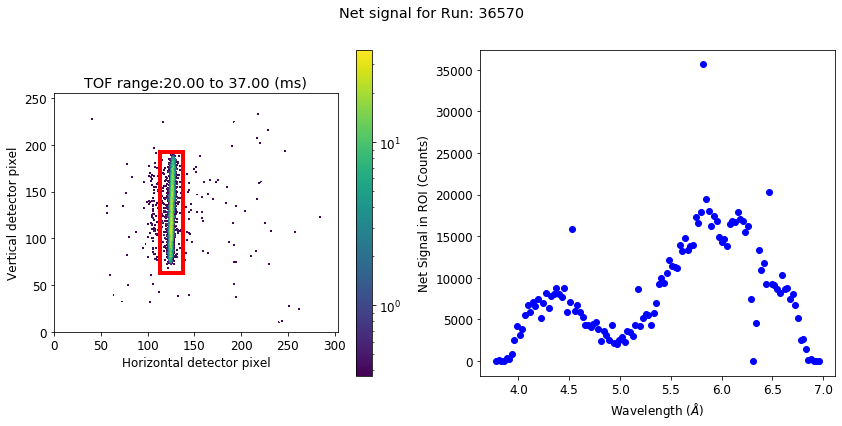

Run Number: 36600
2Theta angle: 4.24 (-0.01)
C0Log_value: 176.0, expected RBP: 128.0
	TOF: 20.14 36.65 [ms]
		c0H: 124.1 (2.6)
		c0V: 127.5 (34.4)
			ROI limits: 112 137 63 193
			Bkg limits: 90 162 25 230
			Signal in background ROI before subtraction: 931.0
			Signal in background ROI after subtraction: 7.102E+02
			Contribution of background to variance is: 3.578E-02 /voxol/state
				ROI limits: 112 137 63 193
					p-charge for state Off_Off: 46251274000.0
						TwoTheta intended: 4.238110832
						TwoTheta   offset: 0.41904812362780514
						TwoTheta   actual: 4.168272574623442


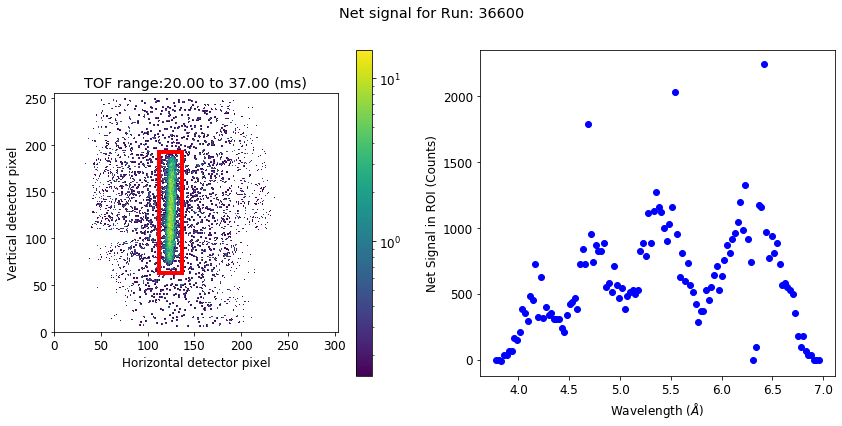

Run Number: 36640
2Theta angle: 7.96 (-0.01)
C0Log_value: 176.0, expected RBP: 128.0
	TOF: 20.07 36.73 [ms]
		c0H: 121.2 (4.2)
		c0V: 126.4 (40.9)
			ROI limits: 109 134 61 191
			Bkg limits: 90 159 25 230
			Signal in background ROI before subtraction: 29854.0
			Signal in background ROI after subtraction: 4.527E+02
			Contribution of background to variance is: 1.804E-02 /voxol/state
				ROI limits: 109 134 61 191
					p-charge for state Off_Off: 1085725500000.0
						TwoTheta intended: 7.955616404000001
						TwoTheta   offset: 0.41671399910203305
						TwoTheta   actual: 7.833401267860023


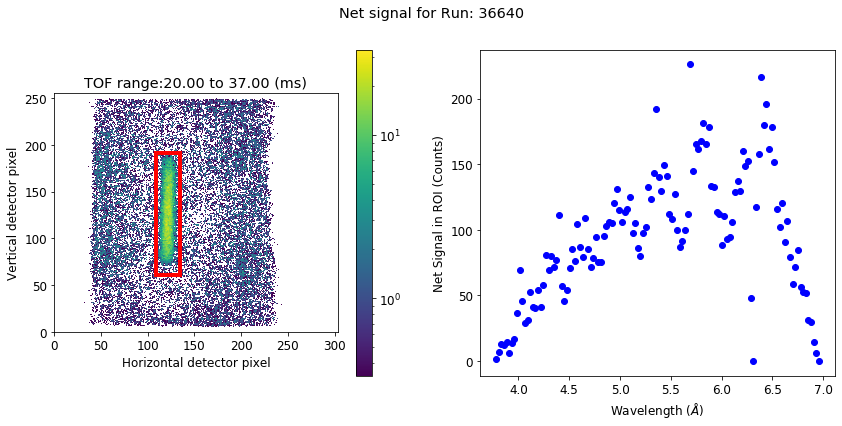

Run Number: 36662
2Theta angle: 10.00 (-0.01)
C0Log_value: 176.0, expected RBP: 128.0
	TOF: 20.07 36.73 [ms]
		c0H: 123.1 (5.4)
		c0V: 124.2 (48.1)
			ROI limits: 111 136 59 189
			Bkg limits: 90 161 25 230
			Signal in background ROI before subtraction: 191791.0
			Signal in background ROI after subtraction: 4.975E+00
			Contribution of background to variance is: 7.776E-02 /voxol/state
				ROI limits: 111 136 59 189
					p-charge for state Off_Off: 6297454400000.0
						TwoTheta intended: 9.998330153999998
						TwoTheta   offset: 0.41904789966505884
						TwoTheta   actual: 9.911033506218065


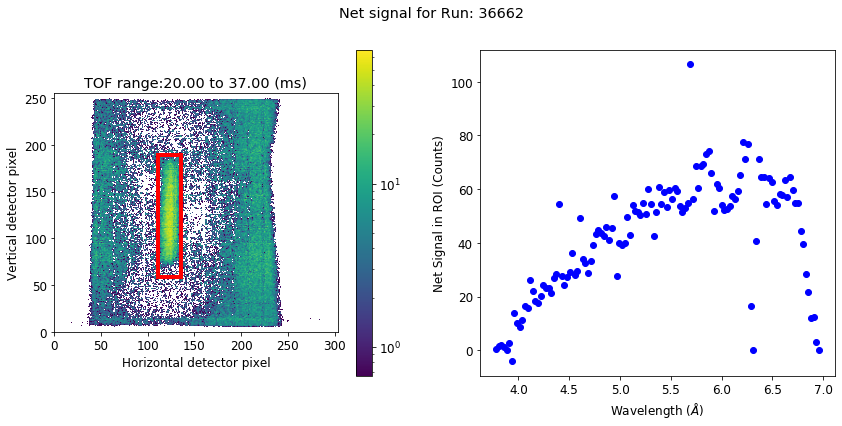

In [3]:
###### This bit of code will check whether the user defined a range with the '-' symbol. If so create a continuous range of run numbers
if any('-' in s for s in run_numbers):
    i,j = int(run_numbers[0]),int(run_numbers[len(run_numbers)-1])
    if j<i:
        j,i = i,j
    run_numbers = []
    for k in range(i,j+1,1):
        run_numbers.append(str(k))
print('Run numbers to be processed:')
print(run_numbers)
MaxRunNumber = len(run_numbers)

for RunIndex in range(MaxRunNumber):
    
    Input_File_Base = directory_path+'input/'+run_numbers[RunIndex]+'_events_' 
    Output_File_Base = directory_path+run_numbers[RunIndex]+'_output' 

# Check if file exists (unpolarized data file use Off_Off extension)
    data_is = os.path.isfile(Input_File_Base+'Off_Off'+'.npz') or os.path.isfile(Input_File_Base+'On_On'+'.npz')\
              or os.path.isfile(Input_File_Base+'On_Off'+'.npz') or os.path.isfile(Input_File_Base+'Off_On'+'.npz')

    if not data_is:
        print('Data files not found: %s'%Input_File_Base)
        raise SystemExit('Files not found, stopping.')
        
# Load some data
    all_data, all_log = load_some_data(Input_File_Base)

# map to variables
    active_spin_states = all_data[0]

    t0_time_Off_Off = all_data[1]
    t0_time_string_Off_Off = all_data[2]
    tof_Off_Off = all_data[3]
    pixel_id_Off_Off = all_data[4]
    pcharge_Off_Off = all_data[5]

    t0_time_On_Off = all_data[6]
    t0_time_string_On_Off = all_data[7]
    tof_On_Off = all_data[8]
    pixel_id_On_Off = all_data[9]
    pcharge_On_Off = all_data[10]

    t0_time_Off_On = all_data[11]
    t0_time_string_Off_On = all_data[12]
    tof_Off_On = all_data[13]
    pixel_id_Off_On = all_data[14]
    pcharge_Off_On = all_data[15]

    t0_time_On_On = all_data[16]
    t0_time_string_On_On = all_data[17]
    tof_On_On = all_data[18]
    pixel_id_On_On = all_data[19]
    pcharge_On_On = all_data[20]   

    pixel_to_coordinate= all_log[0]
    Source_Sample_Distance= all_log[1]
    Sample_Detector_Center_Distance= all_log[2]
    TemperatureLog_times= all_log[3]
    TemperatureLog_value= all_log[4]
    DANGLELog_times= all_log[5]
    DANGLELog_value= all_log[6]
    DANGLE0Log_times= all_log[7]
    DANGLE0Log_value= all_log[8]
    SANGLELog_times= all_log[9]
    SANGLELog_value= all_log[10]
    C0Log_times= all_log[11]
    C0Log_value= all_log[12]
    ChopperFreqLog_times= all_log[13]
    ChopperFreqLog_value= all_log[14]
    LambdaBarLog_times= all_log[15]
    LambdaBarLog_value= all_log[16]
    EMagLog_times= all_log[17]
    EMagLog_value= all_log[18]

    print('Run Number: %s'%run_numbers[RunIndex])
    print('2Theta angle: %.2f (%.2f)'%(DANGLELog_value[0],DANGLE0Log_value[0]))    
    
# Bin the data, the BL4A detector is 304 pixels in the reflection plane and 256 normal to it

    n = 304 # number of horizontal detector pixels for BL4A
    m = 256 # number of vertical detector pixels for BL4A

# The metadata file should contain the magic pixel where the direct beam appears in horiz-pixel for twotheta=0
# The code assumes the specular beam will also be close to this value for all twotheta because theta:2theta geometry used.
# In this notebook small two theta appears to the left side of an image, on BL4A the orientation is reversed
#
    print('C0Log_value: %s, expected RBP: %s'%(C0Log_value[0],n-C0Log_value[0]))

    tof_min=np.max([np.min(tof_On_Off),np.min(tof_Off_Off)]) # need to expand options for all states
    tof_max=np.max([np.max(tof_On_Off),np.max(tof_Off_Off)]) # note we will address user limits before writing files

    print('\tTOF: %.2f %.2f [ms]'%(tof_min/1000,tof_max/1000))

    bin_data = bin_the_data(n,m,tof_min,tof_max,tbins,active_spin_states, \
                            pixel_id_Off_Off,pixel_id_On_Off,pixel_id_Off_On,pixel_id_On_On, \
                            tof_Off_Off,tof_On_Off,tof_Off_On,tof_On_On)
    tof = bin_data[0]
    e_map = bin_data[1]
    var_e_map = copy.deepcopy(e_map) # e_map contains counts, so the variance is counts
    
# Find the ROI

    t_range = [tof_min,tof_max] # microseconds range over which to integrate can be changed by user
    t_integration = np.zeros([n,m,4], dtype=np.float32) 

    a0,i0 = find_nearest(tof,t_range[0])
    a1,i1 = find_nearest(tof,t_range[1])

    for sdx in range(4):
        t_integration[:,:,sdx]=np.sum(e_map[:,:,i0:i1,sdx],axis=2) # integrate over all time in range
    ts_integration = np.sum(t_integration,axis=2) # integrate over all spin states
    
    if MakePlot:
        vmax = np.max(ts_integration)
        plt.figure(figsize = (10,10))
        plt.xlabel('Horizontal detector pixel', fontsize=18)
        plt.ylabel('Vertical detector pixel', fontsize=18)
        plt.title('%s: Binned raw data\n TOF range: %.2f to %.2f (ms) '%(run_numbers[RunIndex],tof_min/1000,tof_max/1000), fontsize=18)
        plt.imshow(np.transpose(ts_integration,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
        plt.colorbar()
        plt.show()
        
# assemble h-projection and estimate ROI
    x_index = np.arange(n)
    h_projection = np.sum(ts_integration,axis=1)
# Add some shadow detection at extremes
# in horizontal search from 0 to hlo and from hhi to :
    hlo = 30
    hhi = n-100
    derr = 10
    hmask_lo = int(np.max(np.where(np.gradient(h_projection[0:hlo])==np.max(np.gradient(h_projection[0:hlo])))[0]) + hlo + derr)
    hmask_hi = int(np.min(np.where(np.gradient(h_projection[hhi:])==np.min(np.gradient(h_projection[hhi:])))[0]) + hhi - derr)

# look for left shadow

    h0_std = np.std(h_projection[0:hmask_lo]) #region which may have a shadow
    h1_std = np.std(h_projection[hmask_lo:hmask_lo+2*derr]) #region for comparison
    left_shadow = False
    if h0_std > 2*h1_std:
        left_shadow = True
    else:
        hmask_lo = 0
    
# look for right shadow

    h0_std = np.std(h_projection[hmask_hi:])
    h1_std = np.std(h_projection[hmask_hi-2*derr:hmask_hi])
    right_shadow = False
    if h0_std > 2*h1_std:
        right_shadow = True
    else:
        hmask_hi = n-1        

    if shadow_custom: # user over-ride of automoatic shadow inspection
        hmask_lo = hmask_lo_custom
        hmask_hi = hmask_hi_custom

# The following determine initial guesses for peak fitting
    mu = np.average(x_index[hmask_lo:hmask_hi], weights=h_projection[hmask_lo:hmask_hi])
    var = np.average(x_index[hmask_lo:hmask_hi]**2, weights=h_projection[hmask_lo:hmask_hi]) - mu**2
    std = np.min([6.,np.sqrt(var)])  # The value of 6 pixels from rms width is typical for BL4A, this attempts to protect against a clearly wrong estimate
    d = np.mean(h_projection[hmask_lo:hmask_hi])
    a = np.amax(h_projection[hmask_lo:hmask_hi]) - d # a,b,c define parameters of a Gaussian peak
    b = mu
    c = std
    e = 0.
    f = 0.
    g = n/2
    
    LowerBounds = [0.,hmask_lo,std/10,0.,0.,0.,0.]
    UpperBounds = [2*a,hmask_hi,hmask_hi-hmask_lo,2*(a+d),2*(a+d),2*(a+d),n]
    try:
        popt, pcov = opt.curve_fit(gaussian_and_poly, x_index[hmask_lo:hmask_hi], h_projection[hmask_lo:hmask_hi], p0=[a,b,c,d,e,f,g], bounds=(LowerBounds,UpperBounds))
        fx = gaussian_and_poly(np.arange(n),*popt)

    except RuntimeError: # execute a fit to a simpler function if above fails
        LowerBounds = [0.,hmask_lo,std/10,0.,0.]
        UpperBounds = [2*a,hmask_hi,hmask_hi-hmask_lo,a*(a+d),2*(a+d)]
        popt, pcov = opt.curve_fit(gaussian_and_line, x_index[hmask_lo:hmask_hi], h_projection[hmask_lo:hmask_hi], p0=[a,b,c,d,e], bounds=(LowerBounds,UpperBounds))    
        fx = gaussian_and_line(np.arange(n),*popt)
    

    centroid = popt[1]
    rms_width = np.abs(popt[2])    

# Find c0 along horizontal direction
    g,c0h = find_nearest(x_index,centroid)
    g0h,roi_0h = find_nearest(x_index,c0h-np.fix(np.abs(rms_width)+0.5)*4)
    g1h,roi_1h = find_nearest(x_index,c0h+np.fix(np.abs(rms_width)+0.5)*4)

# ensure ROI is inside shadow mask
    roi_0h = np.max([roi_0h,hmask_lo+1])
    roi_1h = np.min([roi_1h,hmask_hi-1])

    if MakePlot:
        plt.figure(figsize = (10,10))
        plt.xlabel('Horizontal detector pixel', fontsize=18)
        plt.ylabel('Counts ', fontsize=18)
        plt.title('Signal integrated over vertical', fontsize=18)
        plt.plot(range(n),h_projection, 'bo')
        plt.plot(range(n),fx,'r')
        plt.plot([c0h,c0h],[0,np.max(fx)],'g')
        plt.plot([c0h-rms_width/2,c0h+rms_width/2],[np.max(fx)/2,np.max(fx)/2],'g')
        plt.show()
    
    print('\t\tc0H: %.1f (%.1f)'%(centroid,rms_width))

# assemble v-projection and estimate ROI
    y_index = np.arange(m)
    v_projection = np.sum(ts_integration[int(c0h-dx/2):int(c0h+dx/2),:],axis=0) # take advantage of knowing c0h to discriminate against background
# Add some shadow detection at extremes
# in vertical search from 0 to hlo and from hhi to :
    vlo = 30
    vhi = m-50
    derr = 10
    vmask_lo = int(np.max(np.where(np.gradient(v_projection[0:vlo])==np.max(np.gradient(v_projection[0:vlo])))[0]) + vlo + derr)
    vmask_hi = int(np.min(np.where(np.gradient(v_projection[vhi:])==np.min(np.gradient(v_projection[vhi:])))[0]) + vhi - derr)

# look for bottom shadow

    v0_std = np.std(v_projection[0:vmask_lo])
    v1_std = np.std(v_projection[vmask_lo:vmask_lo+2*derr])
    bottom_shadow = False
    if v0_std > 2*v1_std:
        bottom_shadow = True
    else:
        vmask_lo = 0

# look for top shadow

    v0_std = np.std(v_projection[vmask_hi:])
    v1_std = np.std(v_projection[vmask_hi-2*derr:vmask_hi])
    top_shadow = False
    if v0_std > 2*v1_std:
        top_shadow = True
    else:
        vmask_hi = m-1        

    if shadow_custom: # user over-ride of automoatic shadow inspection
        vmask_lo = vmask_lo_custom
        vmask_hi = vmask_hi_custom
        v_projection[0:vmask_lo] = 0
        v_projection[vmask_hi:-1] = 0

    mu = np.average(y_index, weights=v_projection)
    var = np.average(y_index**2, weights=v_projection) - mu**2
    std = np.sqrt(var)    
    d = np.mean(v_projection)
    a = np.amax(v_projection) - d
    b = mu
    c = std
    e = 0.
    f = 0.
    g = m/2
    
    LowerBounds = [0.,vmask_lo,std/3,0.,0.,0.,0.]
    UpperBounds = [2*a,vmask_hi,vmask_hi-vmask_lo,2*(a+d),2*(a+d),2*(a+d),m]

    try:
        popt, pcov = opt.curve_fit(gaussian_and_poly, y_index[vmask_lo:vmask_hi], v_projection[vmask_lo:vmask_hi], p0=[a,b,c,d,e,f,g], bounds=(LowerBounds,UpperBounds))
        fx = gaussian_and_poly(np.arange(m),*popt)

    except RuntimeError: # execute if above fails
        LowerBounds = [0.,vmask_lo,std/3,0.,0.]
        UpperBounds = [2*a,vmask_hi,vmask_hi-vmask_lo,2*(a+d),2*(a+d)]
        popt, pcov = opt.curve_fit(gaussian_and_line, y_index[vmask_lo:vmask_hi], v_projection[vmask_lo:vmask_hi], p0=[a,b,c,d,e], bounds=(LowerBounds,UpperBounds))
        fx = gaussian_and_line(np.arange(m),*popt)
    
    centroid = popt[1]
    rms_width = np.abs(popt[2])
# Find c0 along the vertical direction
    g,c0v = find_nearest(x_index,centroid)
    g0v,roi_0v = find_nearest(y_index,c0v-np.fix(np.abs(rms_width)+0.5)*3)
    g1v,roi_1v = find_nearest(y_index,c0v+np.fix(np.abs(rms_width)+0.5)*3)

# ensure ROI is inside shadow mask
    roi_0v = np.max([roi_0v,vmask_lo+1])
    roi_1v = np.min([roi_1v,vmask_hi-1])

    if MakePlot:
        plt.figure(figsize = (10,10))
        plt.xlabel('Vertical detector pixel', fontsize=18)
        plt.ylabel('Counts ', fontsize=18)
        plt.title('Signal integrated over horizontal', fontsize=18)
        plt.plot(v_projection, 'bo')
        plt.plot(fx,'r')
        plt.plot([c0v,c0v],[0,np.max(fx)],'g')
        plt.plot([c0v-rms_width/2,c0v+rms_width/2],[np.max(fx)/2,np.max(fx)/2],'g')
        plt.show()
        
    print('\t\tc0V: %.1f (%.1f)'%(centroid,rms_width))
    
# will over-ride computer ROI selection with width and height specified by user centered about peak center at (c0h,c0v)
    if UserPreference:
        roi_0h = int(c0h - dx/2+0.5)
        roi_1h = int(roi_0h + dx+0.5)
        roi_0v = int(c0v - dy/2+0.5)
        roi_1v = int(roi_0v + dy+0.5)
        hmask_lo = np.max([roi_0h - dx,hmask_lo])
        hmask_hi = np.min([roi_1h + dx,hmask_hi])
        vmask_lo = np.max([roi_0v - dy,vmask_lo])
        vmask_hi = np.min([roi_1v + dy,vmask_hi])
    print('\t\t\tROI limits: %s %s %s %s'%(roi_0h,roi_1h,roi_0v,roi_1v))
    print('\t\t\tBkg limits: %s %s %s %s'%(hmask_lo,hmask_hi,vmask_lo,vmask_hi))

# Subtract background
    e2_map = copy.deepcopy(e_map) # create a copy of e_mat so when we change e2_mat, e_mat does not change.
    var_e2_map = copy.deepcopy(var_e_map)

    e2_map_ssum = np.sum(e2_map,axis=3) # sum over all spin states, we assume background is spin indepedent

# need a mask of True to fit data to a background function
    
    mask = np.empty([n,m],dtype=bool)
    mask.fill(True)

#set mask periphery to false
    border = 12 # The detector appears dead at its periphery
    for i in range(border):
        for j in range(m):
            mask[i,j] = False
            mask[n-1-i,j] = False
    for j in range(border):
        for i in range(n):
            mask[i,j] = False
            mask[i,m-1-j] = False

#set mask for shadows to false
    for j in range(m):
        for i in range(hmask_lo):
            mask[i,j] = False
        for i in range(n-1-hmask_hi):
            mask[i+hmask_hi,j] = False
    for i in range(n):
        for j in range(vmask_lo):
            mask[i,j] = False
        for j in range(m-1-vmask_hi):
            mask[i,j+vmask_hi] = False
        
# set mask for interior of ROI
    for i in range(roi_1h-roi_0h):
        for j in range(roi_1v-roi_0v):
            mask[i+roi_0h,j+roi_0v]=False
            
    if MakePlot:
        plt.figure(figsize = (10,10))
        plt.xlabel('Horizontal detector pixel', fontsize=18)
        plt.ylabel('Vertical detector pixel', fontsize=18)
        plt.title('Mask')
        plt.imshow(np.transpose(mask,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=1))
        plt.show()

    print('\t\t\tSignal in background ROI before subtraction: %s'%np.sum(e2_map_ssum[mask,:]))
    
    bkg_fit = np.zeros((n,m,tbins),dtype=np.float32)

# simplest background is average of unmasked region
    MeanBackgroundPerPixel = np.zeros(tbins)
    for i in range(tbins):
        MeanBackgroundPerPixel[i] = np.sum(e2_map_ssum[mask,i]) / np.sum(mask) / np.sum(active_spin_states) 

    if BackgroundChoice == 'AveragePixel':
        for i in range(tbins):
            bkg_fit[:,:,i] = MeanBackgroundPerPixel[i]

    if BackgroundChoice == 'FittedPlane' or BackgroundChoice == 'FittedPolynomial': # these fit a non-uniform background
        x,y = np.where(mask) #  i,j for True
        xdata = np.vstack((x.ravel(),y.ravel())) # converts 2 indices to 1D array
        
        x0 = np.zeros(n*m, dtype=np.int32) #x0,y0 have indices for entire background even under ROI
        y0 = np.zeros(n*m, dtype=np.int32)
        k = 0
        for i in range(n):
            for j in range(m):
                x0[k] = i
                y0[k] = j
                k = k + 1
        xdata0 = np.vstack((x0.ravel(),y0.ravel())) # converts 2 indices to 1D array

    for k in range(tbins):
        if BackgroundChoice == 'FittedPlane':
            f_map = e2_map_ssum[mask,k]/np.sum(active_spin_states) # average of all active states
            initial_guesses = [MeanBackgroundPerPixel[k],0.,0.]
            popt, pcov = opt.curve_fit(linear_surface, xdata, f_map.ravel(), p0=initial_guesses)
            bkg_fit[x0,y0,k] = linear_surface(xdata0, *popt)  # this is background to be subtracted from every spin state
        if BackgroundChoice == 'FittedPolynomial':
            f_map = e2_map_ssum[mask,k]/np.sum(active_spin_states) # average of all active states
            initial_guesses = [MeanBackgroundPerPixel[k],0.,0.,1e-6,c0h,1e-6,c0v]
            popt, success = opt.leastsq(errfunc, initial_guesses[:], args=(xdata, f_map.ravel()))
            bkg_fit[x0,y0,k] = func(popt, xdata0)  # this is background to be subtracted from every spin state

    for k in range(tbins): # kept separate from above because we have three background options requiring this step
        for i in range(4):
            if active_spin_states[i]==1:
                e2_map[:,:,k,i] = e2_map[:,:,k,i] - bkg_fit[:,:,k]
                var_e2_map[:,:,k,i] = var_e2_map[:,:,k,i] + np.abs(bkg_fit[:,:,k]) #add varinace of background, protect if negative

    e2_map_ssum = np.sum(e2_map,axis=3) # sum over all spin states, we assume background is spin independent

    if MakePlot:
        plt.figure(figsize = (10,10))
        plt.xlabel('Horizontal detector pixel', fontsize=18)
        plt.ylabel('Vertical detector pixel', fontsize=18)
        plt.title('Background integrated over all TOF')
        q_image = np.sum(bkg_fit[:,:,:],axis=2)
        vmax = np.max(q_image)
        plt.imshow(np.transpose(q_image,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
        plt.colorbar()
        plt.show()

        xx = np.sum(e_map[:,:,:,0],axis=2)
        yy = np.sum(bkg_fit[:,:,:],axis=2)
        vv = np.sum(e2_map[:,:,:,0],axis=2)
        xx = np.sum(xx[:,int(c0v-dy/2):int(c0v+dy/2)],axis=1)
        yy = np.sum(yy[:,int(c0v-dy/2):int(c0v+dy/2)],axis=1)
        vv = np.sum(vv[:,int(c0v-dy/2):int(c0v+dy/2)],axis=1)
        plt.figure(figsize = (10,10))
        plt.xlabel('Horizontal detector pixel', fontsize=18)
        plt.ylabel('Signal integrated over all TOF in small vertical region', fontsize=18)
        plt.ylim(0,np.max(xx))
        plt.plot(range(n),xx,'bo', label = 'Before background subtraction')
        plt.plot(range(n),yy,'r', label = 'Estimate of background')
        plt.plot(range(n)[hmask_lo:hmask_hi],vv[hmask_lo:hmask_hi],'go', label = 'In ROI After background subtraction')
        plt.legend(loc='upper right', fontsize='x-large')
        plt.show()
                
# Set variable name consistent with reflectometry workflow document.
# D3_mat is the variable containing the data after background subtraction
    D3_mat = e2_map
    var_D3_mat = var_e2_map

    print('\t\t\tSignal in background ROI after subtraction: %.3E'%np.sum(e2_map_ssum[mask,:]))
    print('\t\t\tContribution of background to variance is: %.3E /voxol/state'%(np.sum(bkg_fit)/n/m/tbins))
    
# will overwrite computer ROI selection for specular peak integration with width and height specified by user
    if UserPreference:
        roi_0h = int(c0h - dx/2+0.5)
        roi_1h = int(roi_0h + dx+0.5)
        roi_0v = int(c0v - dy/2+0.5)
        roi_1v = int(roi_0v + dy+0.5)
        
    ROImask = np.empty([n,m],dtype=bool)
    ROImask.fill(False)    
# set mask for interior of ROI, integrated peak only where ROImask is True
    for i in range(roi_1h-roi_0h):
        for j in range(roi_1v-roi_0v):
            ROImask[i+roi_0h,j+roi_0v]=True

    if MakePlot:
        plt.figure(figsize = (10,10))
        plt.xlabel('Horizontal detector pixel', fontsize=18)
        plt.ylabel('Vertical detector pixel', fontsize=18)
        plt.title('ROI Mask')
        plt.imshow(np.transpose(ROImask,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=1))
        plt.show()
                        
    print('\t\t\t\tROI limits: %s %s %s %s'%(roi_0h,roi_1h,roi_0v,roi_1v))

    D4_mat = np.sum(D3_mat[ROImask,:,:],axis=0) # integrate net signal in ROI
    var_D4_mat = np.sum(var_D3_mat[ROImask,:,:],axis=0)
# Normalize by p-charge
    p_Uni = 7.455e11 # universal proton charge value, this is the sum of pcharge for 1C exposure (~716 s at 1.4MW)

# Obtain the total proton charge accumulated during the run.
# Find the unique t0s, their indices, then sum pcharge over these indices
    run_charge = np.zeros(4, dtype=np.float32) #contains integrated p charge for each spin state for the run

    state = 'Off_Off'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        u_value,u_idx = np.unique(t0_time_Off_Off,return_index=True)
        run_charge[sdx] = np.sum(pcharge_Off_Off[u_idx])
        print('\t\t\t\t\tp-charge for state %s: %s'%(state,run_charge[sdx]))
    
    state = 'On_Off'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        u_value,u_idx = np.unique(t0_time_On_Off,return_index=True)
        run_charge[sdx] = np.sum(pcharge_On_Off[u_idx])
        print('Total accumulated proton charge for state %s: %s'%(state,run_charge[sdx]))

    state = 'Off_On'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        u_value,u_idx = np.unique(t0_time_Off_On,return_index=True)
        run_charge[sdx] = np.sum(pcharge_Off_On[u_idx])
        print('Total accumulated proton charge for state %s: %s'%(state,run_charge[sdx]))
    
    state = 'On_On'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        u_value,u_idx = np.unique(t0_time_On_On,return_index=True)
        run_charge[sdx] = np.sum(pcharge_On_On[u_idx])
        print('Total accumulated proton charge for state %s: %s'%(state,run_charge[sdx]))

# Normalize run to the univerisal p-charge
    D5p_mat = np.zeros((tbins,4), dtype=np.float32)
    var_D5p_mat = np.zeros((tbins,4), dtype=np.float32)

    for i in range(4):
        if run_charge[i]!=0:
            D5p_mat[:,i] = D4_mat[:,i] * (p_Uni / run_charge[i])
            var_D5p_mat[:,i] = var_D4_mat[:,i] * (p_Uni / run_charge[i])**2
            
# Produce wavelength, two_theta, intensity, variance
# Create two_theta array
# the coordinates from pixel-to-coordinate are: z [m], psi (in scattering plane) [radians], phi [radians]
# z is distance from sample to detector pixel
# phi is the angle from bottom to top of detector ranging from 0 to m-1 (most negative to most positive)
# psi is the two_theta angle in horizontal plane ranging from 0 to n-1 (smallest to largest scattering angle)
# for n/2 the two_theta angle is DANGLE0 in radians
# User locates the dbp and rbp (if theta:2theta held) at C0Log_value[0], this corresponds to DANGLE0, not n/2

    PixelOffset = n - C0Log_value[0]
    z,psi,phi = pixel_to_coordinate[int(PixelOffset*m+c0v),:] #scattering angle within detector
    tthOffset = DANGLELog_value[0]/180*Pi - psi # this accounts for where the user put the dbp/rbp instead of n/2
    
    z,psi,phi = pixel_to_coordinate[int(c0h*m+c0v),:] #scattering angle within detector
    two_theta = psi + tthOffset # apply the offset    

    print('\t\t\t\t\t\tTwoTheta intended: %s'%DANGLELog_value[0])
    print('\t\t\t\t\t\tTwoTheta   offset: %s'%(tthOffset*180/Pi))
    print('\t\t\t\t\t\tTwoTheta   actual: %s'%(two_theta*180/Pi))
    

# reset if user specified limits
    if tof_user:
        tof_min = tof_min_user
        tof_max = tof_max_user

# Do the wavelength binning

    l_mod_sample = Source_Sample_Distance # moderator to sample (meters)
    l_sample_det = Sample_Detector_Center_Distance #sample to detector (meters), could be z for tth_off but differ very little (ppm)
    l_mod_det = l_mod_sample + l_sample_det #moderator to detector (meters)

    WaveMin = 2*Pi*hbar/m_n/(l_mod_det/(tof_min*1e-6))*1e10 # to get in Angstroms
    WaveMax = 2*Pi*hbar/m_n/(l_mod_det/(tof_max*1e-6))*1e10 # to get in Angstroms
    
    WaveActual = 2*Pi*hbar/m_n/(l_mod_det/(tof*1e-6))*1e10 # to get in Angstroms
    
    if LogBin:
        p = int(np.log(WaveMax/WaveMin)/np.log(1+rel_dLambda)+1)+1
        WaveBins = np.zeros(p, dtype=np.float32)
        for i in range(p):
            WaveBins[i]=(1+rel_dLambda)**i*WaveMin # tof values for start of each bin
    else:
        p = tbins
        WaveBins = np.linspace(WaveMin,WaveMax,p)
    
# Assume only one spin state in the first channel
# from here on we assume unpolarized beam experiment and only write the off_off state
# need to flesh this out for polarized beam.  MF
#
    S, VarS = np.zeros(p-1, dtype=np.float32), np.zeros(p-1, dtype=np.float32)
    WaveLength = np.zeros(p-1, dtype=np.float32)

    OutStrings = []

    for i in range(p-1):
        b = WaveActual <= WaveBins[i+1]
        c = WaveActual > WaveBins[i]
        d = b & c
    
        S[i] = np.sum(D5p_mat[d,0])
        VarS[i] = np.sum(var_D5p_mat[d,0])
        WaveLength[i] = (WaveBins[i]+WaveBins[i+1])/2.

        OutStrings.append('%.10f\t%.10f\t%.10f\t%.10f\n'%(WaveLength[i],two_theta,S[i],VarS[i]))

    OFile = open(Output_File_Base+'.txt', 'w')
    for item in OutStrings:
        OFile.write(item)
    OFile.close()
    
# For plotting
    t_range = [tof_min,tof_max] # microseconds range over which to integrate can be changed by user
    t_integration = np.zeros([n,m,4], dtype=np.float32) 

    a0,i0 = find_nearest(tof,t_range[0])
    a1,i1 = find_nearest(tof,t_range[1])

    for sdx in range(4):
        t_integration[:,:,sdx]=np.sum(D3_mat[:,:,i0:i1,sdx],axis=2) # integrate over all time in range
    ts_integration = np.sum(t_integration,axis=2) # integrate over all spin states

    vmax = np.max(ts_integration)
    e_image = ts_integration
    
# Plot images of data if desired
    if MakePlot:
        plt.figure(figsize = (10,10))
        plt.xlabel('Horizontal detector pixel', fontsize=18)
        plt.ylabel('Vertical detector pixel', fontsize=18)
        plt.title('%s: Net signal (Linear Scale)\n TOF range:%.2f to %.2f (ms)'%(run_numbers[RunIndex],tof_min/1000,tof_max/1000), fontsize=18)
        plt.imshow(np.transpose(e_image,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax))
        plt.plot([roi_0h,roi_1h],[roi_0v,roi_0v], c = 'r', linewidth = 4)
        plt.plot([roi_1h,roi_1h],[roi_0v,roi_1v], c = 'r', linewidth = 4)
        plt.plot([roi_1h,roi_0h],[roi_1v,roi_1v], c = 'r', linewidth = 4)
        plt.plot([roi_0h,roi_0h],[roi_1v,roi_0v], c = 'r', linewidth = 4)    
        plt.colorbar()
        plt.show()
        
# Plot summary plots
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize = (14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.suptitle('Net signal for Run: %s'%run_numbers[RunIndex])
    ax1.set(xlabel='Horizontal detector pixel', ylabel='Vertical detector pixel', title='TOF range:%.2f to %.2f (ms)'%(tof_min/1000,tof_max/1000))
    ax2.set(xlabel='Wavelength ($\AA$)', ylabel='Net Signal in ROI (Counts)')
    im = ax1.imshow(np.transpose(e_image,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.01*vmax, vmax=vmax))    
    ax1.plot([roi_0h,roi_1h],[roi_0v,roi_0v], c = 'r', linewidth = 4)
    ax1.plot([roi_1h,roi_1h],[roi_0v,roi_1v], c = 'r', linewidth = 4)
    ax1.plot([roi_1h,roi_0h],[roi_1v,roi_1v], c = 'r', linewidth = 4)
    ax1.plot([roi_0h,roi_0h],[roi_1v,roi_0v], c = 'r', linewidth = 4)    
    fig.colorbar(im,ax=ax1)
    ax2.plot(WaveLength, S, 'bo')
    plt.show()
